# Methow Boxplots

In [5]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as cx
import scipy.stats
import matplotlib.dates as mdates
from matplotlib.ticker import FuncFormatter
from matplotlib.lines import Line2D
import datetime
import pickle
from scipy import stats
import matplotlib.cbook as cbook

In [6]:
%matplotlib inline

In [7]:
plt.rcParams['figure.facecolor']='w'
plt.rcParams['axes.facecolor']='w'
plt.rcParams['savefig.facecolor']='w'

plt.rcParams['font.size'] = '16'

In [8]:
pd.set_option('display.max_columns', None)

In [14]:
mpl_epoch = '1970-01-01'

In [15]:
def iqr(x):
    IQR = stats.iqr(x, interpolation = 'midpoint', nan_policy='omit')
    return IQR

### Load in the saved data:

In [17]:
#atl06sr_gdf = pickle.load(open('../../../data/atl06/methow_all_sr-atl06-10172022_processed.pkl', 'rb'))
atl06sr_gdf = pickle.load(open('../../../data/atl06/methow_all_sr-atl06-10172022_processed_bicubic_7912.pkl', 'rb'))

outline_gdf = pickle.load(open('../../../data/site_outlines/methow_outline_32610.pkl', 'rb'))

methow_reverse = pickle.load(open('../../../data/site_outlines/methow_reverse.pkl', 'rb'))

snwd = pickle.load(open('../../data/snotel/snotel_snwd_35.pkl', 'rb'))
snwd_65 = pickle.load(open('../../data/snotel/snotel_snwd_65.pkl', 'rb'))
snotel_sites = pickle.load(open('../../data/snotel/snotel_sites_65.pkl', 'rb'))

snotel_geom = pickle.load(open('../../data/snotel/snotel_geometries.pkl', 'rb'))

cso_methow = pickle.load(open('../../../data/cso/cso-data.pkl', 'rb'))

/var/folders/yr/1f67jccn6hl_lyxnqy7qjpq40000gp/T/ipykernel_3274/130042338.py:4: UserWarning: Unpickling a shapely <2.0 geometry object. Please save the pickle again; shapely 2.1 will not have this compatibility.
  outline_gdf = pickle.load(open('../../../data/site_outlines/methow_outline_32610.pkl', 'rb'))
/var/folders/yr/1f67jccn6hl_lyxnqy7qjpq40000gp/T/ipykernel_3274/130042338.py:6: UserWarning: Unpickling a shapely <2.0 geometry object. Please save the pickle again; shapely 2.1 will not have this compatibility.
  methow_reverse = pickle.load(open('../../../data/site_outlines/methow_reverse.pkl', 'rb'))
/var/folders/yr/1f67jccn6hl_lyxnqy7qjpq40000gp/T/ipykernel_3274/130042338.py:10: UserWarning: Unpickling a shapely <2.0 geometry object. Please save the pickle again; shapely 2.1 will not have this compatibility.
  snotel_sites = pickle.load(open('../../data/snotel/snotel_sites_65.pkl', 'rb'))
/var/folders/yr/1f67jccn6hl_lyxnqy7qjpq40000gp/T/ipykernel_3274/130042338.py:12: UserWarning

In [18]:
atl06sr_gdf = atl06sr_gdf.rename(columns={'diff_plus_bicubic_update':'diff_plus_bicubic'})

### Remove Outliers using a z-score filter and absolute value filter:  

In [19]:
atl06sr_gdf['zscore'] = (atl06sr_gdf['diff_plus_bicubic'] - atl06sr_gdf['diff_plus_bicubic'].mean()) / atl06sr_gdf['diff_plus_bicubic'].std()

zscore_thresh = 3
absdiff_thresh = 5.0

In [20]:
# trying to get different zscore values for snow on versus snow off values

atl06_idx = (atl06sr_gdf['zscore'].abs() <= zscore_thresh)

inner_snowoff_idx = (atl06sr_gdf['zscore'].abs() <= zscore_thresh) & (atl06sr_gdf['snow_presence'] == 0)
    #(atl06sr_gdf['diff_plus_bicubic'].abs() <=absdiff_thresh) & \
    
inner_snowon_idx = (atl06sr_gdf['zscore'].abs() <= zscore_thresh) & (atl06sr_gdf['snow_presence'] == 1)
    #(atl06sr_gdf['diff_plus_bicubic'].abs() <=absdiff_thresh) & \
    

In [21]:
atl06sr_gdf_inner = atl06sr_gdf[atl06_idx]

### Write function for plotting data:

In [38]:
# Function adapted from David Shean by Hannah Besso
# REMOVE boxplot transparency (which indicated sample size)
plt.rcParams['font.size'] = '16'
def boxplot_date_landsat(df, col, groupby_col='acqdate', 
                         snotel_list=['Muckamuck', 'Salmon Meadows'], 
                         cso_bounds=[0,3000], 
                         title='Difference w Offset', name='boxplots', clim=(-2, 5)):
    
    # Calculate ATL06 stats in a format compatible with ax.bxp
    bp_stats = df[[col, groupby_col]].dropna().groupby(groupby_col).apply(cbook.boxplot_stats)
    bp_stats_list = [i[0] for i in bp_stats.values]
    bp_alpha = df[[col, groupby_col]].dropna().groupby(groupby_col).count().values.ravel()
    bp_alpha_boxes = (bp_alpha-bp_alpha.min())/(bp_alpha.max()-bp_alpha.min()) * (1 - 0.15) + 0.15
    pos = (pd.to_datetime(bp_stats.index) - pd.to_datetime(mpl_epoch)).days.values
    
    # Set subplot layout
    f, ax = plt.subplots(figsize=(15,10))
    
    # Create Snotel color list
    #color_list = ['darkorange', 'lightpink', 'lightcoral', 'violet', 'indigo', 'mediumseagreen']
    
    # plot Snotel and CDEC data
    #snwd_65[snotel_list].plot(ax=ax_dict['A'], lw=1.5, color='darkorange)
    # snwd['Muckamuck'].plot(ax=ax, lw=1.5, color='lightpink')
    # snwd['Salmon Meadows'].plot(ax=ax, lw=1.5, color='darkorange')
    snwd['Muckamuck'].plot(ax=ax, lw=1.5, color = 'darkorange', linestyle='--')
    snwd['Salmon Meadows'].plot(ax=ax, lw=1.5, color = 'lightpink', linestyle='-')
    #snwd[snotel_list].plot(ax=ax, lw=1.5, color = ['darkorange', 'lightpink'], linestyle=['--', '-'])
    cso_methow[(cso_methow['elevation']>cso_bounds[0]) & (cso_methow['elevation']<cso_bounds[1])]['depth_m'].plot(ax=ax, \
                color='lightcoral', linewidth=0, marker='.', label='CSO Probe Measurements')
    ax.axes.get_xaxis().set_ticks([])
    years = mdates.YearLocator(month=10)
    years_fmt = mdates.DateFormatter('%B %Y')
    #ax.format_xdata = mdates.DateFormatter('%d-%m-%Y')
    #years_fmt = mdates.DateFormatter('%d-%m-%Y')
    ax.xaxis.set_major_locator(years)
    ax.xaxis.set_major_formatter(years_fmt)
    # Plot ATL06 data
    bxp_f = ax.bxp(bp_stats_list, positions=pos, showfliers=False, showcaps=False, 
                   whiskerprops={'lw':0.5, 'alpha':0}, boxprops= {'lw':0, 'alpha':0.2, 'edgecolor':'None'},  
                   widths=10, medianprops={'lw':1.5, 'color':'k'}, patch_artist=True) #
    
    # Create my custom legend
    ax.legend(custom, custom_labels, loc='lower left', prop={'size':18}, fancybox=True, framealpha=0.5)
    
    # Set display keywords for the median lines on the boxplots
    for patch, alpha in zip(bxp_f['medians'], bp_alpha_boxes):
        patch.set_alpha(1)
        patch.set_color('black')  # or deeppink
        patch.set_linewidth(2)
    
    # Plot vertical lines for each landsat acquisition date
    # for date1 in dates[1:]:
    #     ax_dict['A'].axvline(x=date1, ymin=clim[0], ymax=clim[1], c='lightgrey', linestyle='--')
    # Set various plotting parameters
    ax.axhline(0, color='k', lw=0.5)
    ax.set_ylabel('Snow Depth (m)', fontsize=22)
    ax.set_xlabel('Acquisition Date', fontsize=22)
    ax.set_ylim(*clim)
    ax.set_xlim([dt_min_plot, dt_max_plot])
    ax.axes.get_xaxis().set_ticks([])
    plt.xticks(color='w')
    plt.title('Methow Valley, Wa', fontsize=24)
    #ax_dict['A'].set_title(title) 
    #ax.set_xlabel('')
    
    # if (datetime.strptime(dt_max_plot, '%Y-%m-%d') - datetime.strptime(dt_min_plot, '%Y-%m-%d')).days <= 366:
    #     months = mdates.MonthLocator()
    #     #ax.format_xdata = mdates.DateFormatter('%B')
    #     months_fmt = mdates.DateFormatter('%B')
    #     ax.xaxis.set_major_locator(months)
    #     ax.xaxis.set_major_formatter(months_fmt)
    #     months = mdates.MonthLocator()
    #     #ax.xaxis.set_minor_locator(months)
    #     #ax.xaxis.set_minor_formatter(months_fmt)        
    #     #ax.format_xdata = mdates.DateFormatter('%B-%Y')
    # else:
    # X AXIS LABELS     
    months = mdates.MonthLocator()
    month_fmt = mdates.DateFormatter('%b')

    def m_fmt(x, pos=None):
        return month_fmt(x)[0]

    ax.xaxis.set_minor_locator(months) 
    ax.xaxis.set_minor_formatter(FuncFormatter(m_fmt))

    years = mdates.MonthLocator(bymonth=1)
    ax.format_xdata = mdates.DateFormatter('%Y')
    years_fmt = mdates.DateFormatter('%Y')
    ax.xaxis.set_major_locator(years)
    ax.xaxis.set_major_formatter(years_fmt)
    ax.tick_params('both', length=5, width=2, which='major')
    
    for label in ax.get_xticklabels(which='major'): #
        label.set(rotation=90, horizontalalignment='center')
    
    
    plt.tight_layout()
    plt.savefig(f'../../figures/polished/{name}.jpeg', dpi=500)

In [30]:
from datetime import datetime

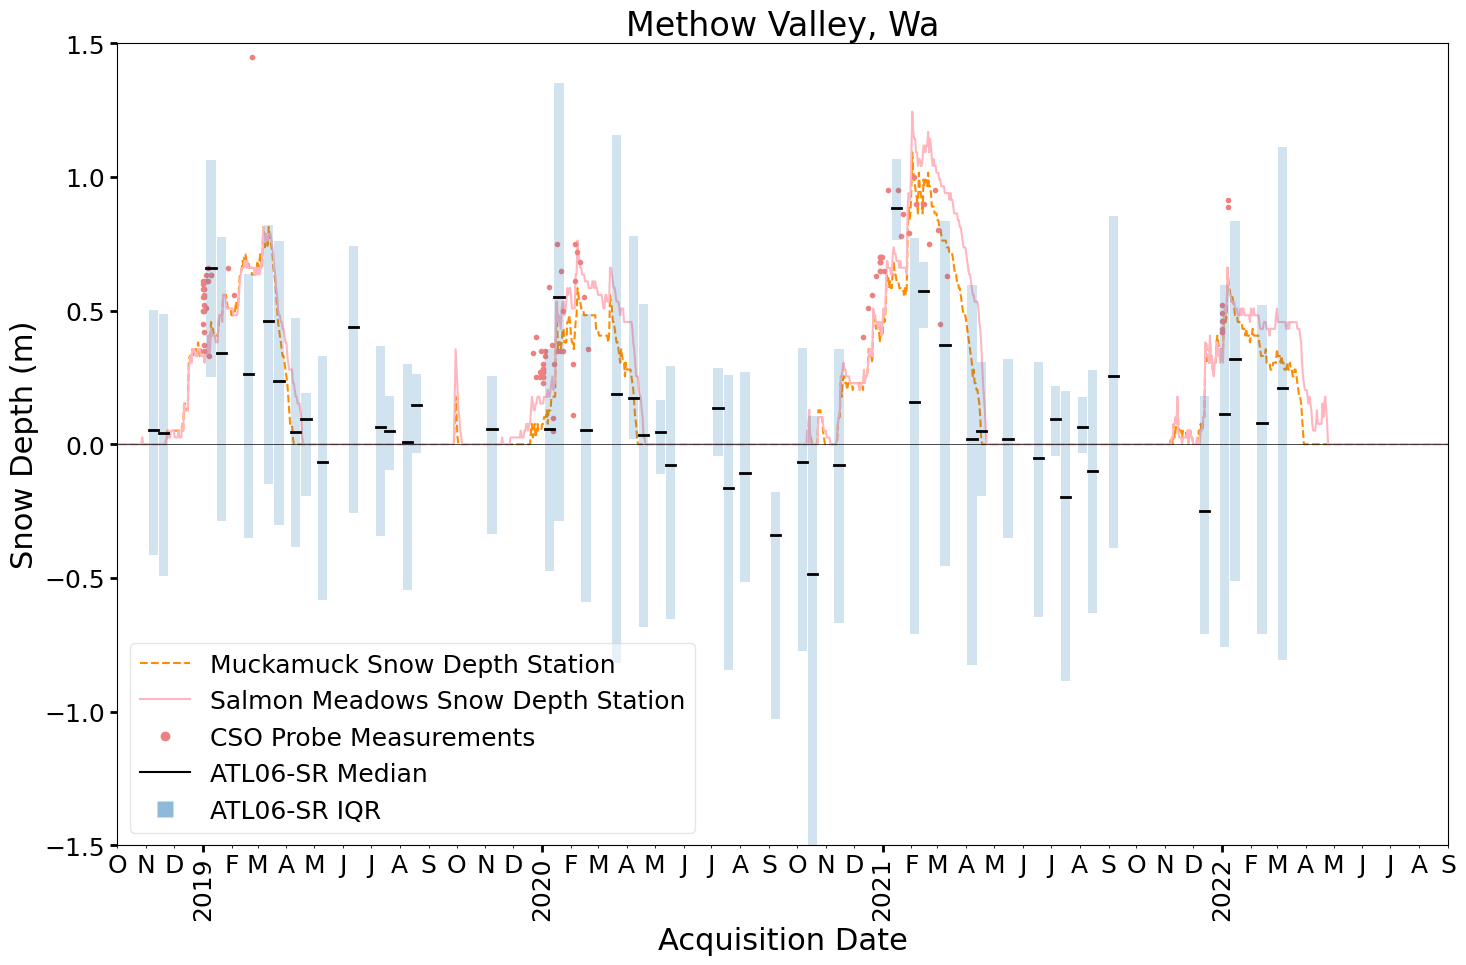

In [39]:
boxplot_color = (31/255,119/255, 180/255, 0.5)

custom = [Line2D([], [], linestyle='--', color='darkorange'),
          Line2D([], [], linestyle='-', color='lightpink'),
          Line2D([], [], marker='.', markersize=12, color='lightcoral', linestyle='None'),
          Line2D([], [], linestyle='-', color='k'),
          Line2D([], [], marker='s', markersize=12, markeredgecolor='none', color=boxplot_color, linestyle='None')
          ]
    
plt.rcParams['font.size'] = '18'
custom_labels = ['Muckamuck Snow Depth Station', 'Salmon Meadows Snow Depth Station', 'CSO Probe Measurements', 'ATL06-SR Median', 'ATL06-SR IQR'] #'CSO Probe Measurements',

dt_min_plot = '2018-10-01'
dt_max_plot = '2022-09-01'
boxplot_date_landsat(df=atl06sr_gdf_inner, col='diff_plus_bicubic', clim=(-1.5,1.5), name='boxplots_diffplus_snotel_cso_atl06sr_paper_dates', title='All Diff Plus')

### Plot water year 2019 for IGARSS presentation:

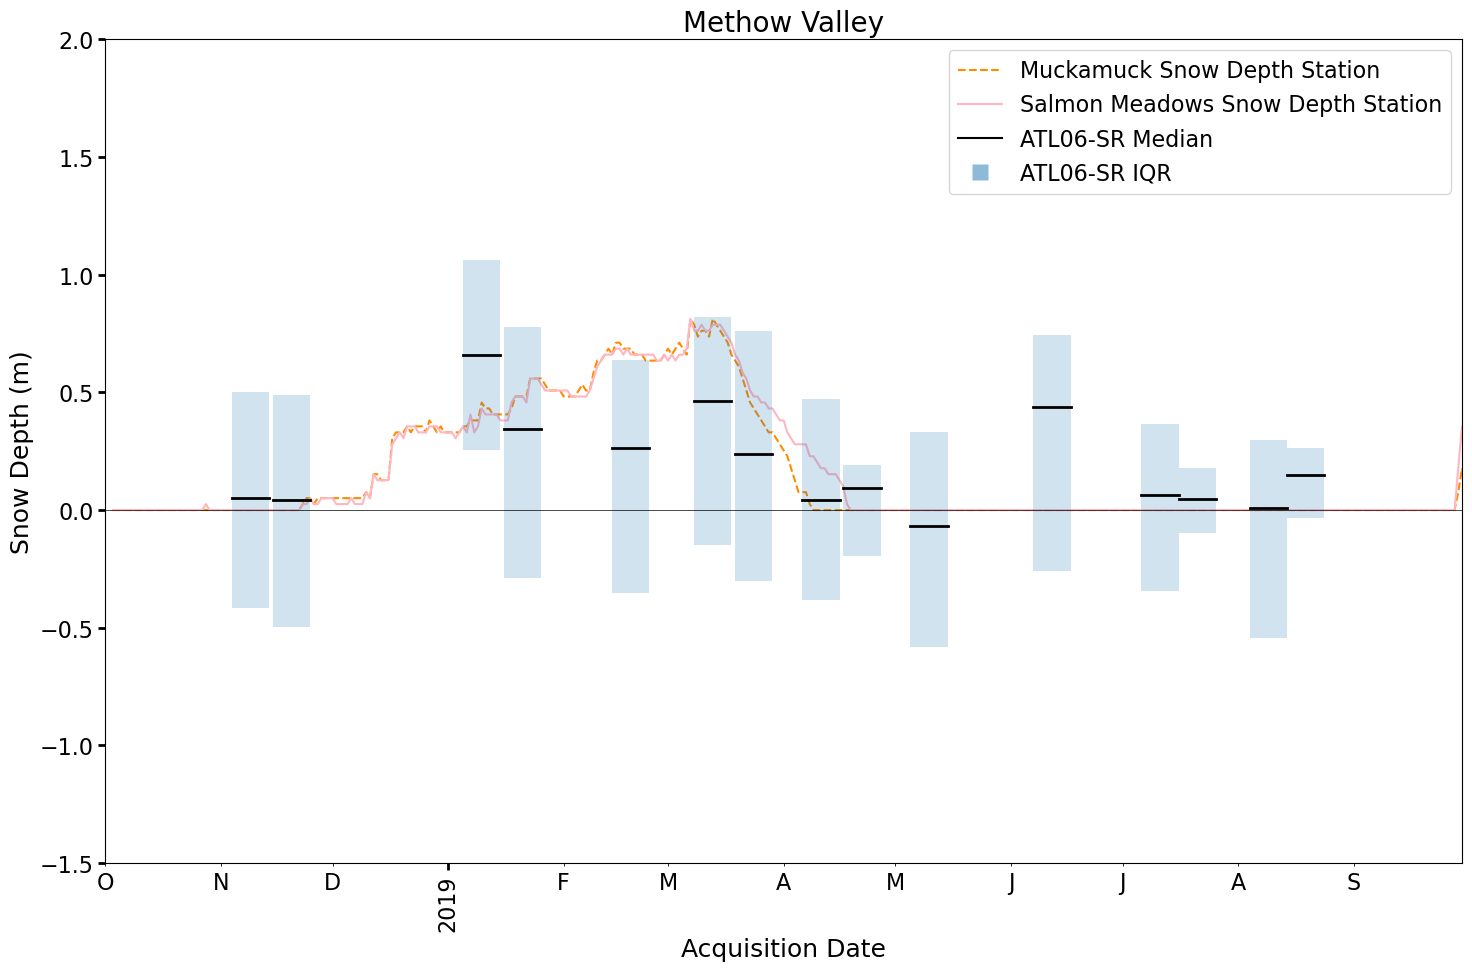

In [76]:
from matplotlib.lines import Line2D
from datetime import datetime

boxplot_color = (31/255,119/255, 180/255, 0.5)

custom = [Line2D([], [], linestyle='--', color='darkorange'),
          Line2D([], [], linestyle='-', color='lightpink'),
          #Line2D([], [], marker='.', markersize=12, color='lightcoral', linestyle='None'),
          Line2D([], [], linestyle='-', color='k'),
          Line2D([], [], marker='s', markersize=12, markeredgecolor='none', color=boxplot_color, linestyle='None')
          ]
    

custom_labels = ['Muckamuck Snow Depth Station', 'Salmon Meadows Snow Depth Station', 'ATL06-SR Median', 'ATL06-SR IQR'] #'CSO Probe Measurements',

dt_min_plot = '2018-10-01'
dt_max_plot = '2019-09-30'
boxplot_date_landsat(df=atl06sr_gdf_inner, col='diff_plus_bicubic', clim=(-1.5,2), name='boxplots_diffplus_snotel_atl06sr_2019_pres', title='All Diff Plus')

### Plot data separately for presentations:

In [23]:
# Function adapted from David Shean by Hannah Besso
# REMOVE boxplot transparency (which indicated sample size)
plt.rcParams['font.size'] = '16'
def boxplot_date_landsat(df=None, col=None, groupby_col='acqdate', 
                         snotel_list=['Muckamuck', 'Salmon Meadows'], 
                         cso_bounds=[0,3000], 
                         title='Difference w Offset', name='boxplots', clim=(-2, 5)):
    
    # Calculate ATL06 stats in a format compatible with ax.bxp
    if df != None:
        bp_stats = df[[col, groupby_col]].dropna().groupby(groupby_col).apply(cbook.boxplot_stats)
        bp_stats_list = [i[0] for i in bp_stats.values]
        bp_alpha = df[[col, groupby_col]].dropna().groupby(groupby_col).count().values.ravel()
        bp_alpha_boxes = (bp_alpha-bp_alpha.min())/(bp_alpha.max()-bp_alpha.min()) * (1 - 0.15) + 0.15
        pos = (pd.to_datetime(bp_stats.index) - pd.to_datetime(mpl_epoch)).days.values
    
    # Set subplot layout
    f, ax = plt.subplots(figsize=(15,10))
    
    # Create Snotel color list
    #color_list = ['darkorange', 'lightpink', 'lightcoral', 'violet', 'indigo', 'mediumseagreen']
    
    # plot Snotel and CDEC data
    #snwd_65[snotel_list].plot(ax=ax_dict['A'], lw=1.5, color='darkorange)
    snwd['Muckamuck'].plot(ax=ax, lw=1.5, linestyle='--', color='darkorange')
    snwd['Salmon Meadows'].plot(ax=ax, lw=1.5, color='lightpink')
    if df != None:
        cso_methow[(cso_methow['elevation']>cso_bounds[0]) & (cso_methow['elevation']<cso_bounds[1])]['depth_m'].plot(ax=ax, \
                color='lightcoral', linewidth=0, marker='.', label='Community Snow Observations')
        ax.axes.get_xaxis().set_ticks([])
        ax.xaxis.set_ticklabels([])
        # Plot ATL06 data
        bxp_f = ax.bxp(bp_stats_list, positions=pos, showfliers=False, showcaps=False, 
                       whiskerprops={'lw':0.5, 'alpha':0}, boxprops= {'lw':0, 'alpha':0.2, 'edgecolor':'None'},  
                       widths=10, patch_artist=True)
    
    # Create my custom legend
    ax.legend(custom, custom_labels, loc='upper right', fontsize=16)
    
    # Set display keywords for the median lines on the boxplots
    if df != None:
        for patch, alpha in zip(bxp_f['medians'], bp_alpha_boxes):
            patch.set_alpha(1)
            patch.set_color('black')  # or deeppink
            patch.set_linewidth(1.5)
    
    # Plot vertical lines for each landsat acquisition date
    # for date1 in dates[1:]:
    #     ax_dict['A'].axvline(x=date1, ymin=clim[0], ymax=clim[1], c='lightgrey', linestyle='--')
    # Set various plotting parameters
    ax.axhline(0, color='k', lw=0.5)
    ax.set_ylabel('Snow Depth (m)', fontsize=18)
    ax.set_xlabel('Acquisition Date', fontsize=18)
    ax.set_ylim(*clim)
    ax.set_xlim([dt_min_plot, dt_max_plot])
    ax.set_title('Methow Valley', fontsize=20)
    #ax_dict['A'].set_title(title) 
    #ax.set_xlabel('')
    
    # One attempt to remove the Jul xaxis label
    # x_axis = ax.axes.get_xaxis()
    # x_axis.set_label_text('foo')
    # x_label = x_axis.get_label()
    # x_label.set_visible(False)
    # Another attempt to remove the Jul xaxis label
    # ax.axes.get_xaxis().set_ticks([])
    # ax.xaxis.set_ticklabels([])
    
     # X AXIS LABELS     
    months = mdates.MonthLocator()
    month_fmt = mdates.DateFormatter('%b')
    
    def m_fmt(x, pos=None):
        return month_fmt(x)[0]
    
    ax.xaxis.set_minor_locator(months) 
    ax.xaxis.set_minor_formatter(FuncFormatter(m_fmt))
    
    years = mdates.MonthLocator(bymonth=1)
    ax.format_xdata = mdates.DateFormatter('%Y')
    years_fmt = mdates.DateFormatter('%Y')
    ax.xaxis.set_major_locator(years)
    ax.xaxis.set_major_formatter(years_fmt)
    ax.tick_params('both', length=5, width=1.5, which='major')
    ax.tick_params('both', length=5, width=1.5, which='minor')
    ax.legend(custom, custom_labels, loc='upper right', prop={'size':16}) #, fontsize=10
    
#     years = mdates.MonthLocator(bymonth=(4, 10))
#     ax.format_xdata = mdates.DateFormatter('%b %d %Y')
#     years_fmt = mdates.DateFormatter('%b %d \n%Y')
#     ax.xaxis.set_major_locator(years)
#     ax.xaxis.set_major_formatter(years_fmt)
#     ax.tick_params('both', length=5, width=2, which='major')
    
    for label in ax.get_xticklabels(which='major'): #
        label.set(rotation=90, horizontalalignment='center')
        
    #ax_dict['A'].annotate(text='I) Snow Depth and Difference Values (ATL06SR -DTM)', xy=(0.02,0.95), xycoords='axes fraction', weight='bold')
    
    # Plot the Landsat imagery below the timeseries plot
    
#     ax_dict['B'].imshow(fsca_dict['March 23 2019'], extent=window_extent)
#     outline_gdf.plot(ax=ax_dict['B'], facecolor='none', edgecolor='magenta')
#     snotel_geom_5km[2:].plot(ax=ax_dict['B'], facecolor='none', edgecolor='magenta')
#     ax_dict['B'].set_title('A) 2019')
#     ax_dict['B'].annotate(text='II) Landsat FSCA', xy=(0,1.2), xycoords='axes fraction', weight='bold')
    
#     ax_dict['C'].imshow(fsca_dict['March 9 2020'], extent=window_extent)
#     outline_gdf.plot(ax=ax_dict['C'], facecolor='none', edgecolor='magenta')
#     snotel_geom_5km[2:].plot(ax=ax_dict['C'], facecolor='none', edgecolor='magenta')
#     ax_dict['C'].set_title('B) 2020')
#     #ax_dict['C'].annotate(text='C)', xy=(-0.12,0.9), xycoords='axes fraction')
    
#     ax_dict['D'].imshow(fsca_dict['Feb 24 2021'], extent=window_extent)
#     outline_gdf.plot(ax=ax_dict['D'], facecolor='none', edgecolor='magenta')
#     snotel_geom_5km[2:].plot(ax=ax_dict['D'], facecolor='none', edgecolor='magenta')
#     ax_dict['D'].set_title('C) 2021')
#     #ax_dict['D'].annotate(text='D)', xy=(-0.12,0.9), xycoords='axes fraction')
    
#     ax_dict['E'].imshow(fsca_dict['Feb 11 2022'], extent=window_extent)
#     outline_gdf.plot(ax=ax_dict['E'], facecolor='none', edgecolor='magenta')
#     snotel_geom_5km[2:].plot(ax=ax_dict['E'], facecolor='none', edgecolor='magenta')
#     ax_dict['E'].set_title('D) 2022')
#     #ax_dict['E'].annotate(text='E)', xy=(-0.12,0.9), xycoords='axes fraction')
    
#     # Set axis color of lansat plots to match the vertical dashed lines, and remove
#     # axis ticks and labels. Also add a scalebar
#     for ax in [ax_dict['B'], ax_dict['C'], ax_dict['D'], ax_dict['E']]:
#         ax.spines['bottom'].set_color('lightgrey')
#         ax.spines['top'].set_color('lightgrey')
#         ax.spines['left'].set_color('lightgrey')
#         ax.spines['right'].set_color('lightgrey')
#         ax.axes.get_xaxis().set_ticks([])
#         ax.axes.get_yaxis().set_ticks([])
#     ax_dict['B'].add_artist(ScaleBar(1, font_properties={'size':8}))
    
    plt.tight_layout()
    plt.savefig(f'../../figures/polished/{name}.jpeg', dpi=500)

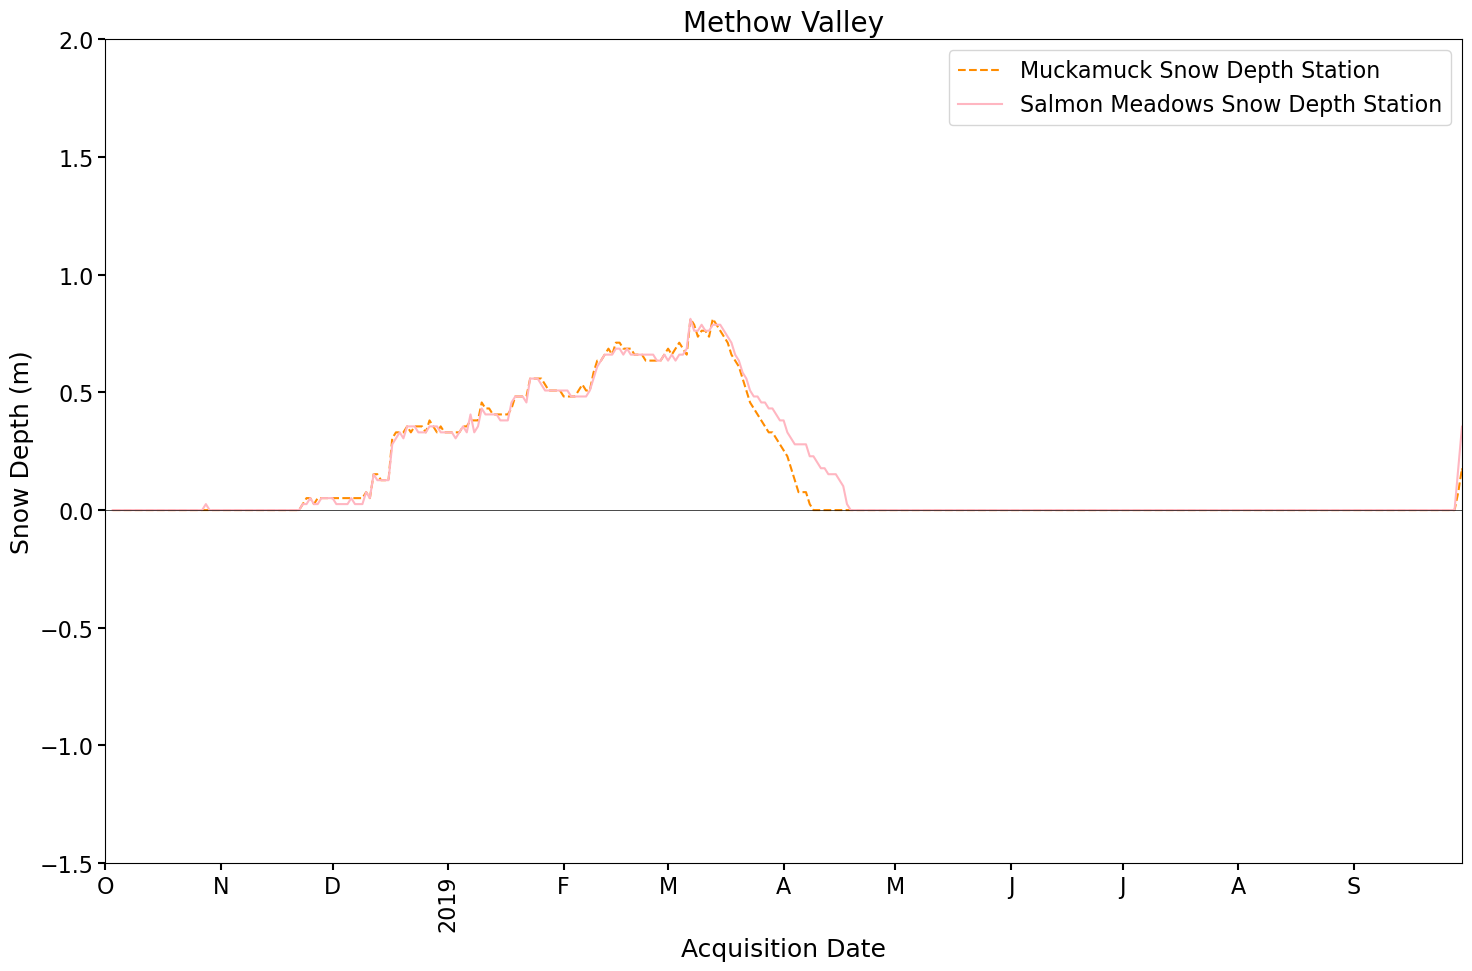

In [79]:
from matplotlib.lines import Line2D

boxplot_color = (31/255,119/255, 180/255, 0.5)

custom = [Line2D([], [], linestyle='--', color='darkorange'),
          Line2D([], [], linestyle='-', color='lightpink'),
          ]
    

custom_labels = ['Muckamuck Snow Depth Station', 'Salmon Meadows Snow Depth Station']

dt_min_plot = '2018-10-01'
dt_max_plot = '2019-09-30'
boxplot_date_landsat(clim=(-1.5,2), name='boxplots_diffplus_snotel_pres', title='All Diff Plus')

In [26]:
from datetime import datetime

In [44]:
# Function adapted from David Shean by Hannah Besso
# REMOVE boxplot transparency (which indicated sample size)
# Contains commented-out code for plotting imagery as well
plt.rcParams['font.size'] = '16'
def boxplot_date_landsat(df=None, col=None, groupby_col='acqdate', 
                         snotel_list=['Muckamuck', 'Salmon Meadows'], 
                         cso_bounds=[0,3000], 
                         title='Difference w Offset', name='boxplots', clim=(-2, 5)):
    
    # Calculate ATL06 stats in a format compatible with ax.bxp
    if df != None:    
        bp_stats = df[[col, groupby_col]].dropna().groupby(groupby_col).apply(cbook.boxplot_stats)
        bp_stats_list = [i[0] for i in bp_stats.values]
        bp_alpha = df[[col, groupby_col]].dropna().groupby(groupby_col).count().values.ravel()
        bp_alpha_boxes = (bp_alpha-bp_alpha.min())/(bp_alpha.max()-bp_alpha.min()) * (1 - 0.15) + 0.15
        pos = (pd.to_datetime(bp_stats.index) - pd.to_datetime(mpl_epoch)).days.values
    
    # Set subplot layout
    f, ax = plt.subplots(figsize=(15,10))
    
    # Create Snotel color list
    #color_list = ['darkorange', 'lightpink', 'lightcoral', 'violet', 'indigo', 'mediumseagreen']
    
    # plot Snotel and CDEC data
    #snwd_65[snotel_list].plot(ax=ax_dict['A'], lw=1.5, color='darkorange)
    snwd['Muckamuck'].plot(ax=ax, lw=1.5, linestyle='--', color='darkorange')
    snwd['Salmon Meadows'].plot(ax=ax, lw=1.5, color='lightpink')
    cso_methow[(cso_methow['elevation']>cso_bounds[0]) & (cso_methow['elevation']<cso_bounds[1])]['depth_m'].plot(ax=ax, \
            color='lightcoral', linewidth=0, marker='.', label='Community Snow Observations')
    ax.axes.get_xaxis().set_ticks([])
    ax.xaxis.set_ticklabels([])
    # Plot ATL06 data
    if df != None:
        bxp_f = ax.bxp(bp_stats_list, positions=pos, showfliers=False, showcaps=False, 
                       whiskerprops={'lw':0.5, 'alpha':0}, boxprops= {'lw':0, 'alpha':0.2, 'edgecolor':'None'},  
                       widths=10, patch_artist=True)
    
    # Create my custom legend
    ax.legend(custom, custom_labels, loc='upper right', fontsize=18)
    
    # Set display keywords for the median lines on the boxplots
    if df != None:
        for patch, alpha in zip(bxp_f['medians'], bp_alpha_boxes):
            patch.set_alpha(1)
            patch.set_color('black')  # or deeppink
            patch.set_linewidth(1.5)
    
    # Plot vertical lines for each landsat acquisition date
    # for date1 in dates[1:]:
    #     ax_dict['A'].axvline(x=date1, ymin=clim[0], ymax=clim[1], c='lightgrey', linestyle='--')
    # Set various plotting parameters
    ax.axhline(0, color='k', lw=0.5)
    ax.set_ylabel('Snow Depth (m)', fontsize=20)
    ax.set_xlabel('Acquisition Date', fontsize=20)
    ax.set_ylim(*clim)
    ax.set_xlim([dt_min_plot, dt_max_plot])
    ax.set_title('Methow Valley', fontsize=24)
    #ax_dict['A'].set_title(title) 
    #ax.set_xlabel('')
    
         # Creating the custom xtick labels that I want
    if (datetime.strptime(dt_max_plot, '%Y-%m-%d') - datetime.strptime(dt_min_plot, '%Y-%m-%d')).days <= 366:
        months = mdates.MonthLocator()
        #ax.format_xdata = mdates.DateFormatter('%B')
        months_fmt = mdates.DateFormatter('%B')
        ax.xaxis.set_major_locator(months)
        ax.xaxis.set_major_formatter(months_fmt)
        months = mdates.MonthLocator()
        #ax.xaxis.set_minor_locator(months)
        #ax.xaxis.set_minor_formatter(months_fmt)        
        #ax.format_xdata = mdates.DateFormatter('%B-%Y')
    else:
        # X AXIS LABELS     
        months = mdates.MonthLocator()
        month_fmt = mdates.DateFormatter('%b')

        def m_fmt(x, pos=None):
            return month_fmt(x)[0]

        ax.xaxis.set_minor_locator(months) 
        ax.xaxis.set_minor_formatter(FuncFormatter(m_fmt))

        years = mdates.MonthLocator(bymonth=1)
        ax.format_xdata = mdates.DateFormatter('%Y')
        years_fmt = mdates.DateFormatter('%Y')
        ax.xaxis.set_major_locator(years)
        ax.xaxis.set_major_formatter(years_fmt)
        ax.tick_params('both', length=5, width=2, which='major')
    
    for label in ax.get_xticklabels(which='major'): #
        label.set(rotation=90, horizontalalignment='center')
    
    
#     ax_dict['B'].imshow(fsca_dict['March 23 2019'], extent=window_extent)
#     outline_gdf.plot(ax=ax_dict['B'], facecolor='none', edgecolor='magenta')
#     snotel_geom_5km[2:].plot(ax=ax_dict['B'], facecolor='none', edgecolor='magenta')
#     ax_dict['B'].set_title('A) 2019')
#     ax_dict['B'].annotate(text='II) Landsat FSCA', xy=(0,1.2), xycoords='axes fraction', weight='bold')
    
#     ax_dict['C'].imshow(fsca_dict['March 9 2020'], extent=window_extent)
#     outline_gdf.plot(ax=ax_dict['C'], facecolor='none', edgecolor='magenta')
#     snotel_geom_5km[2:].plot(ax=ax_dict['C'], facecolor='none', edgecolor='magenta')
#     ax_dict['C'].set_title('B) 2020')
#     #ax_dict['C'].annotate(text='C)', xy=(-0.12,0.9), xycoords='axes fraction')
    
#     ax_dict['D'].imshow(fsca_dict['Feb 24 2021'], extent=window_extent)
#     outline_gdf.plot(ax=ax_dict['D'], facecolor='none', edgecolor='magenta')
#     snotel_geom_5km[2:].plot(ax=ax_dict['D'], facecolor='none', edgecolor='magenta')
#     ax_dict['D'].set_title('C) 2021')
#     #ax_dict['D'].annotate(text='D)', xy=(-0.12,0.9), xycoords='axes fraction')
    
#     ax_dict['E'].imshow(fsca_dict['Feb 11 2022'], extent=window_extent)
#     outline_gdf.plot(ax=ax_dict['E'], facecolor='none', edgecolor='magenta')
#     snotel_geom_5km[2:].plot(ax=ax_dict['E'], facecolor='none', edgecolor='magenta')
#     ax_dict['E'].set_title('D) 2022')
#     #ax_dict['E'].annotate(text='E)', xy=(-0.12,0.9), xycoords='axes fraction')
    
#     # Set axis color of lansat plots to match the vertical dashed lines, and remove
#     # axis ticks and labels. Also add a scalebar
#     for ax in [ax_dict['B'], ax_dict['C'], ax_dict['D'], ax_dict['E']]:
#         ax.spines['bottom'].set_color('lightgrey')
#         ax.spines['top'].set_color('lightgrey')
#         ax.spines['left'].set_color('lightgrey')
#         ax.spines['right'].set_color('lightgrey')
#         ax.axes.get_xaxis().set_ticks([])
#         ax.axes.get_yaxis().set_ticks([])
#     ax_dict['B'].add_artist(ScaleBar(1, font_properties={'size':8}))
    
    plt.tight_layout()
    plt.savefig(f'../../figures/polished/{name}.jpeg', dpi=500)

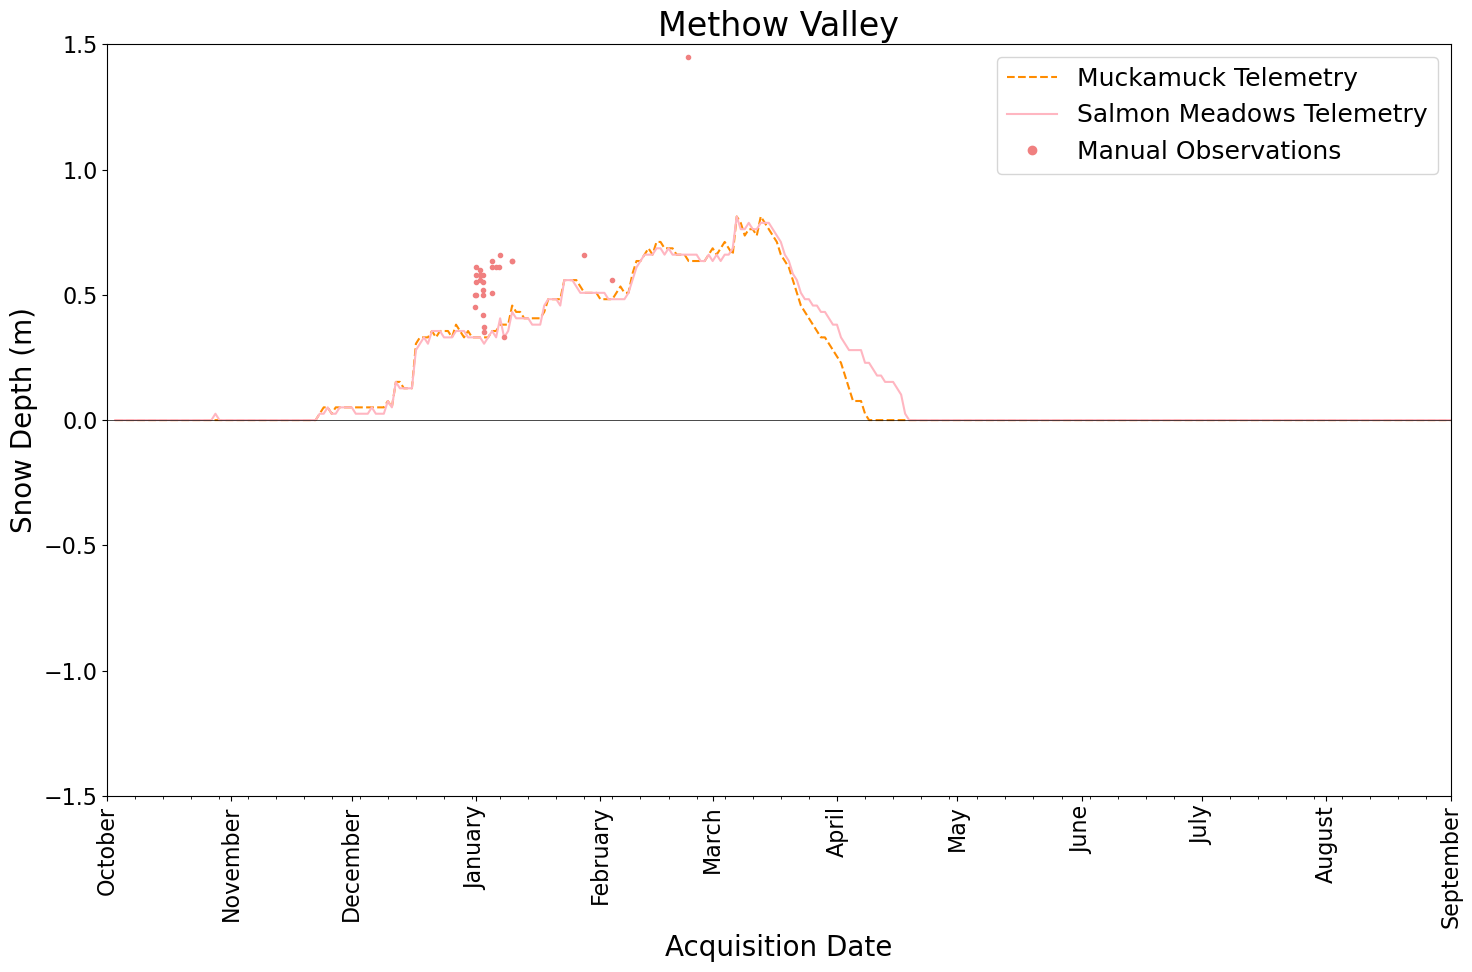

In [45]:
from matplotlib.lines import Line2D

boxplot_color = (31/255,119/255, 180/255, 0.5)

custom = [Line2D([], [], linestyle='--', color='darkorange'),
          Line2D([], [], linestyle='-', color='lightpink'),
          Line2D([], [], marker='.', markersize=12, color='lightcoral', linestyle='None'),
          ]
    

custom_labels = ['Muckamuck Telemetry', 'Salmon Meadows Telemetry', 'Manual Observations']

dt_min_plot = '2018-10-01'
dt_max_plot = '2019-09-01'
boxplot_date_landsat(clim=(-1.5,1.5), name='boxplots_diffplus_snotel_cso_pres', title='All Diff Plus')

## Old Code  
### Used boxplot transparency to indicate sample size

In [22]:
snotel_list=['Muckamuck', 'Salmon Meadows']
color_list = ['darkorange', 'lightpink', 'lightcoral']
color_list[0:len(snotel_list)]

['darkorange', 'lightpink']

In [17]:
# Function adapted from David Shean by Hannah Besso
# Uses boxplot transparency to indicate sample size

def boxplot_date_aso_all(df, col, col_aso=None, rasterstats=False, groupby_col='acqdate', 
                         groupby_col_aso='ASO_snowon_date', snotel_list=['Muckamuck', 'Salmon Meadows'], 
                         cso_bounds=[0,3000], region_aso=outline_gdf, 
                         title='Difference w Offset', name='boxplots', clim=(-2, 5)):
    # ATL06 stats
    bp_stats = df[[col, groupby_col]].dropna().groupby(groupby_col).apply(cbook.boxplot_stats)
    bp_stats_list = [i[0] for i in bp_stats.values]
    bp_alpha = df[[col, groupby_col]].dropna().groupby(groupby_col).count().values.ravel()
    bp_alpha_boxes = (bp_alpha-bp_alpha.min())/(bp_alpha.max()-bp_alpha.min()) * (1 - 0.15) + 0.15
    pos = (pd.to_datetime(bp_stats.index) - pd.to_datetime(mpl_epoch)).days.values
    
    # ASO Snow-On Stats tracks
    if col_aso != None:
        bp_stats2 = df[[col_aso, groupby_col_aso]].dropna().groupby(groupby_col_aso).apply(cbook.boxplot_stats)
        bp_stats_list2 = [i[0] for i in bp_stats2.values]
        bp_alpha2 = df[[col_aso, groupby_col_aso]].dropna().groupby(groupby_col_aso).count().values.ravel()
        bp_alpha_boxes2 = bp_alpha2/bp_alpha2.max()
        pos2 = (pd.to_datetime(bp_stats2.index) - pd.to_datetime(mpl_epoch)).days.values 
    
    # ASO Snow-On Stats whole region
    if rasterstats:
        stats_dict = build_bp_stats(aso_fn_winters, region_aso)
        bp_alpha_boxes3 = stats_dict[2]/stats_dict[2].max()
    
    f, ax = plt.subplots(figsize=(20,10))
    
    #snwd[['tum_m', 'dan_m']].plot(ax=ax, lw=2, style=['--','-'])
    # snwd['Muckamuck'].plot(alpha=1, color='darkorange', lw=2, label='Muckamuck')
    # snwd['Salmon Meadows'].plot(alpha=1, color='lightpink', lw=2, label='Salmon Meadows')
    color_list = ['darkorange', 'lightpink', 'lightcoral', 'violet', 'indigo', 'mediumseagreen']
    snwd_65[snotel_list].plot(ax=ax, lw=2, color=color_list[0:len(snotel_list)])
    cso_methow[(cso_methow['elevation']>cso_bounds[0]) & (cso_methow['elevation']<cso_bounds[1])]['depth_m'].plot(ax=ax, \
            color='k', linewidth=0, marker='.')
    #snwd_65.iloc[:,0:9].plot(ax=ax, lw=2)
    # Plot ATL06 data
    bxp_f = ax.bxp(bp_stats_list, positions=pos, showfliers=False, showcaps=False, 
                   whiskerprops={'lw':0.5, 'alpha':0.2}, boxprops= {'lw':1},  
                   medianprops={'lw':3},widths=10, patch_artist=True)
    # Plot ASO snow on data
    if col_aso != None:
        bxp_f2 = ax.bxp(bp_stats_list2, positions=pos2, showfliers=False, showcaps=False, 
                    whiskerprops={'lw':0.5, 'alpha':0.2}, boxprops= {'lw':1}, 
                    medianprops={'lw':3}, widths=10, patch_artist=True)
    if rasterstats:
        bxp_f3 = ax.bxp(stats_dict[0], positions=stats_dict[1], showfliers=False, showcaps=False, 
                        whiskerprops={'lw':0.5, 'alpha':0.2}, boxprops= {'lw':1, 'alpha':1}, 
                        medianprops={'lw':3, 'color':'purple'}, widths=10, patch_artist=True)
    
    for patch, alpha in zip(bxp_f['boxes'], bp_alpha_boxes):
        patch.set_edgecolor('None')
        patch.set_linewidth(0)
    if col_aso != None:
        for patch, alpha in zip(bxp_f2['boxes'], bp_alpha_boxes2):
            patch.set_color('mediumvioletred')
    if rasterstats:
        for patch, alpha in zip(bxp_f3['boxes'], bp_alpha_boxes3):
            patch.set_facecolor('grey')
            patch.set_edgecolor('none')
            patch.set_alpha(alpha)
            #patch.set_hatch('o')
    
    # https://stackoverflow.com/questions/47528955/adding-a-legend-to-a-matplotlib-boxplot-with-multiple-plots-on-same-axes
    # https://stackoverflow.com/questions/12761806/matplotlib-2-different-legends-on-same-graph
    legend1 = ax.legend(loc='lower right', title='SNOTEL Snow Depth')
    legend1.set_alpha(1)
    if rasterstats:
        legend2 = ax.legend([bxp_f["boxes"][0], bxp_f2["boxes"][0], bxp_f3['boxes'][0]], ['ATL06SR', 'ASO Tracks', 'ASO Basin'], loc='upper left', title='Boxplots')
    elif col_aso != None:
        legend2 = ax.legend([bxp_f["boxes"][0], bxp_f2["boxes"][0]], ['ATL06SR', 'ASO Tracks'], loc='upper left', title='Boxplots') 
    else:
        legend2 = ax.legend([bxp_f['boxes'][0]], ['ATL06SR'], loc='upper left', title='Boxplots')
    ax.add_artist(legend1)
    ax.add_artist(legend2)
    
    #set the ATL06SR alpha (transparency) for each box, whisker, and median according to the number of samples for that measurement
    for patch, alpha in zip(bxp_f['boxes'], bp_alpha_boxes):
        patch.set_alpha(alpha)
        patch.set_edgecolor('None')
        patch.set_linewidth(0)
    for patch, alpha in zip(bxp_f['medians'], bp_alpha_boxes):
        patch.set_alpha(alpha)
        patch.set_color('white')  # or deeppink
    #double the alpha list since there are 2 whiskers per box (https://datagy.io/python-combine-lists/)
    for patch, alpha in zip(bxp_f['whiskers'], [item for sublist in zip(bp_alpha_boxes, bp_alpha_boxes) for item in sublist]):
        patch.set_alpha(alpha)
        
    #set the ASO Snow On tracks alpha (transparency) for each box, whisker, and median according to the number of samples for that measurement
    if col_aso != None:
        for patch, alpha in zip(bxp_f2['boxes'], bp_alpha_boxes2):
            patch.set_alpha(alpha)    
        for patch, alpha in zip(bxp_f2['medians'], bp_alpha_boxes2):
            patch.set_alpha(alpha)
            patch.set_color('white')  # or deeppink
        #double the alpha list since there are 2 whiskers per box (https://datagy.io/python-combine-lists/)
        for patch, alpha in zip(bxp_f2['whiskers'], [item for sublist in zip(bp_alpha_boxes2, bp_alpha_boxes2) for item in sublist]):
            patch.set_alpha(alpha)   
    
    ax.axhline(0, color='k', lw=0.5)
    ax.set_ylabel('Difference Values (m)')
    ax.set_ylim(*clim)
    ax.set_xlim([dt_min_plot, dt_max_plot])
    ax.set_title(title) 
    
    years = mdates.YearLocator(month=10)
    ax.format_xdata = mdates.DateFormatter('%Y-%m-%d')
    years_fmt = mdates.DateFormatter('%Y-%m-%d')
    ax.xaxis.set_major_locator(years)
    ax.xaxis.set_major_formatter(years_fmt)
    months = mdates.MonthLocator()
    ax.xaxis.set_minor_locator(months)
    
#     months = mdates.MonthLocator()
#     ax.format_xdata = mdates.DateFormatter('%m')
#     months_fmt = mdates.DateFormatter('%m')
#     ax.xaxis.set_major_locator(months)
#     ax.xaxis.set_major_formatter(months_fmt)
    
    plt.tight_layout()
    plt.savefig(f'../../figures/polished/{name}.jpeg', dpi=500)

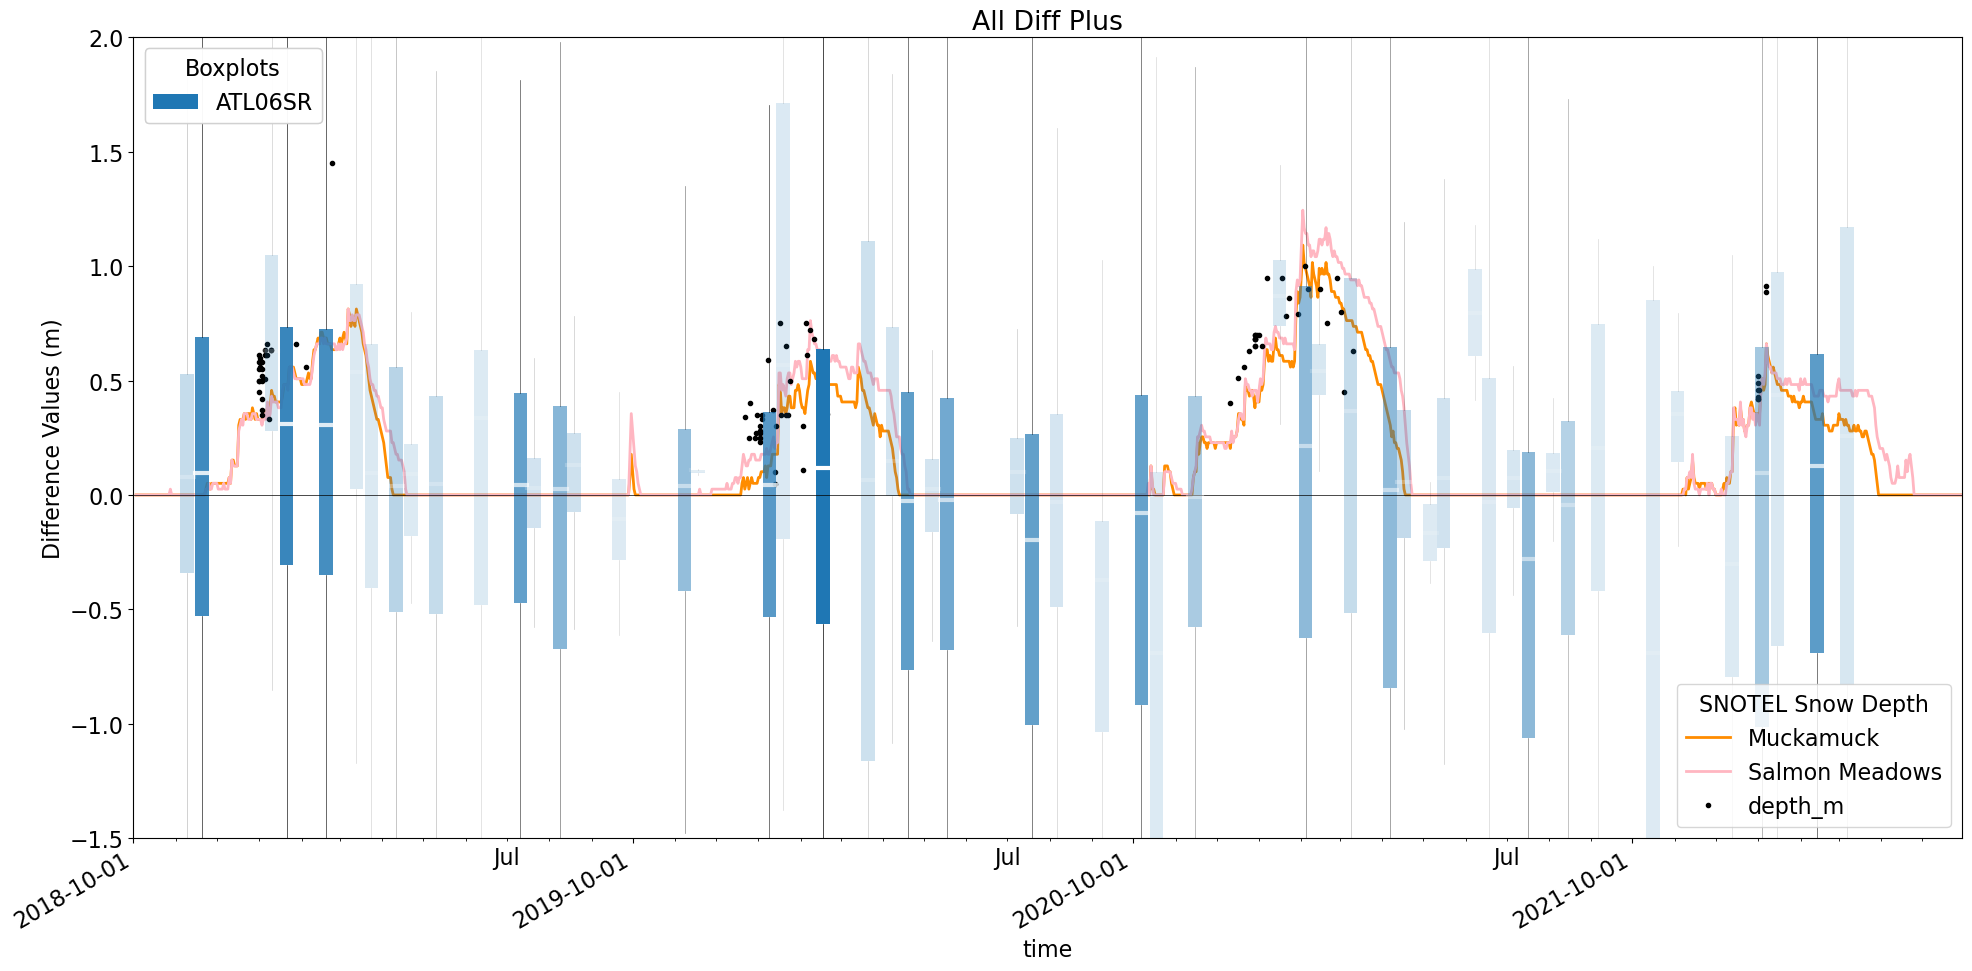

In [18]:
dt_min_plot = '2018-10-01'
dt_max_plot = '2022-05-30'
boxplot_date_aso_all(df=atl06sr_gdf, col='diff_plus', clim=(-1.5,2), name='boxplots_diffplus_transparent', title='All Diff Plus')